## Importing Needed Libraries

In [4]:
import os
import PIL as Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
import tensorflow as tf
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.models import Model

print('modules loaded')

modules loaded


In [2]:
from tensorflow.keras.optimizers import Adamax

## Reading The Dataset

In [5]:
data_dir='Rice_Image_Dataset'
filepath=[]
labels=[]
folds=os.listdir(data_dir)
for fold in folds:
    file_path=os.path.join(data_dir,fold)
    if not os.path.isdir(file_path): # if not a directory, skip
        continue
    fpath = os.listdir(file_path)
    
    for f in fpath:
        fil_path=os.path.join(file_path,f)
        filepath.append(fil_path)
        labels.append(fold)

f_series=pd.Series(filepath,name='filepaths')
l_series=pd.Series(labels,name='labels')
df=pd.concat([f_series, l_series], axis= 1)

In [6]:
df.head()

,filepaths,labels
0,Rice_Image_Dataset/Arborio/Arborio (1).jpg,Arborio
1,Rice_Image_Dataset/Arborio/Arborio (10).jpg,Arborio
2,Rice_Image_Dataset/Arborio/Arborio (100).jpg,Arborio
3,Rice_Image_Dataset/Arborio/Arborio (1000).jpg,Arborio
4,Rice_Image_Dataset/Arborio/Arborio (10000).jpg,Arborio


## EDA

In [7]:
df['labels'].value_counts().sort_index()

labels
Arborio      15000
Basmati      15000
Ipsala       15000
Jasmine      15000
Karacadag    15000
Name: count, dtype: int64

/tmp/ipykernel_2231/726765442.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df['labels'].value_counts().index,y=df['labels'].value_counts().values,palette='viridis')


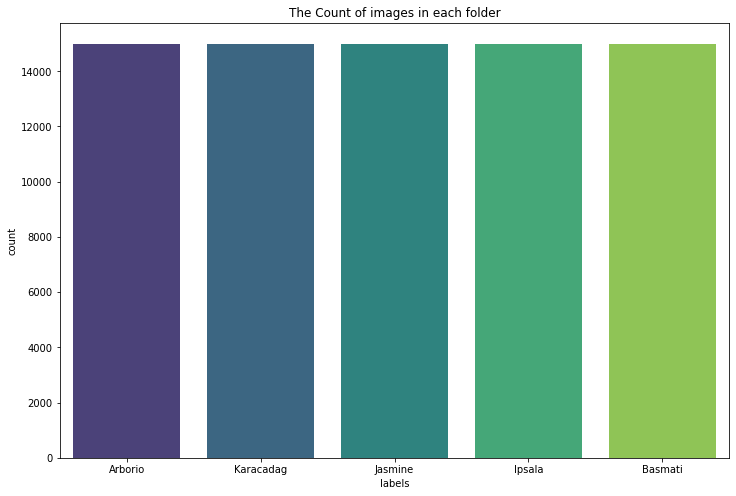

In [8]:
plt.figure(figsize=(12,8))
sns.barplot(x=df['labels'].value_counts().index,y=df['labels'].value_counts().values,palette='viridis')
plt.title('The Count of images in each folder')
plt.xlabel('labels')
plt.ylabel('count')
plt.show()

## Preprocessing The Data

**Splitting The Dataset into Train, Test, and Validate Sets**

In [9]:
train_df,dummy_df=train_test_split(df,test_size=0.2,random_state=42,stratify=df['labels'])
valid_df,test_df=train_test_split(dummy_df,test_size=0.5,random_state=42,stratify=dummy_df['labels'])

**Creating Image Data Genearator**

In [10]:
batch_size = 64
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 60000 validated image filenames belonging to 5 classes.
Found 7500 validated image filenames belonging to 5 classes.
Found 7500 validated image filenames belonging to 5 classes.


**Displaying a Sample from The Data**

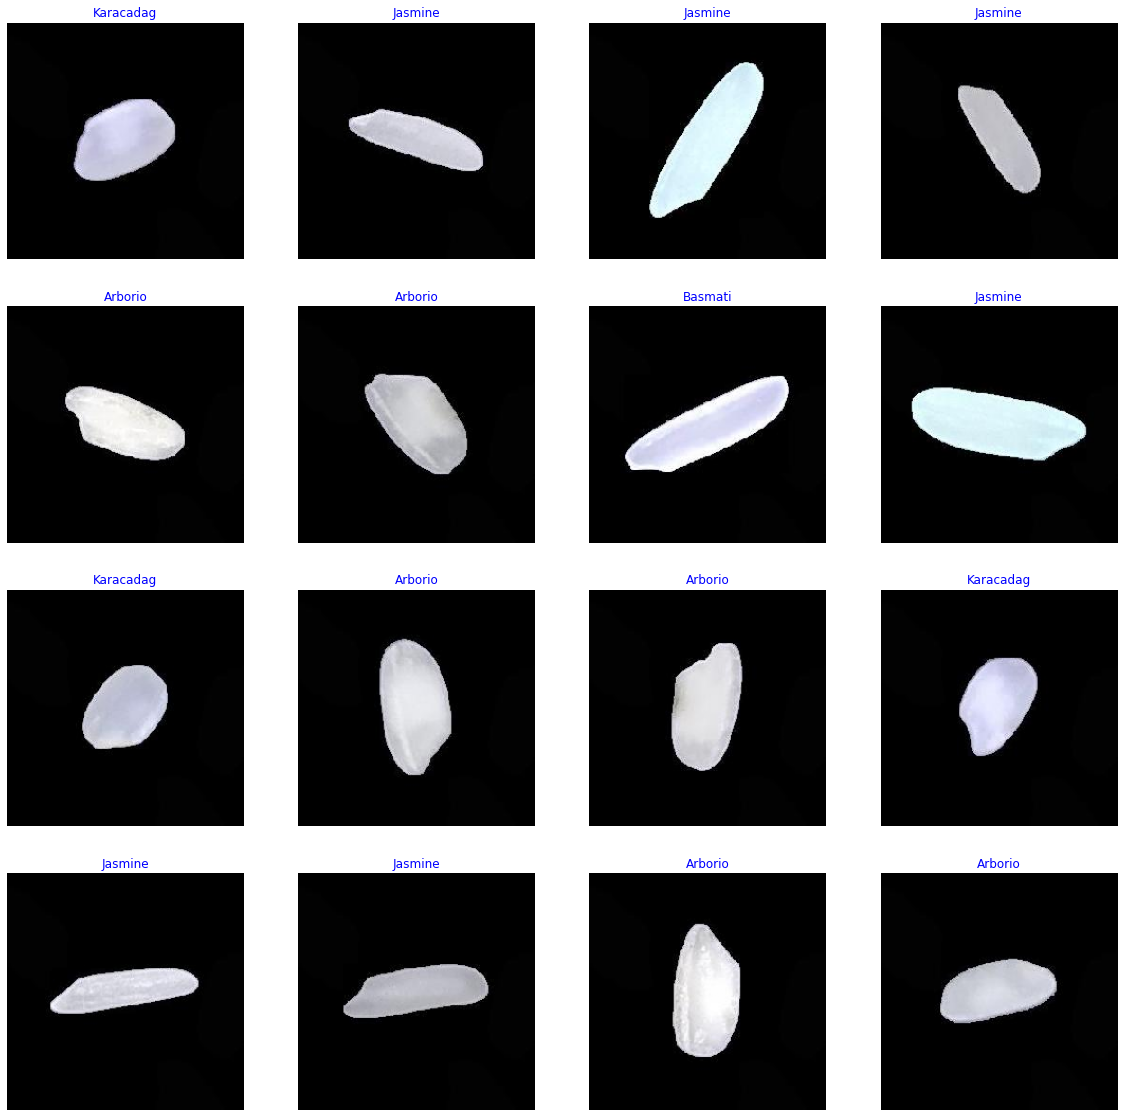

In [11]:
g_dict = train_gen.class_indices    
classes = list(g_dict.keys())      
images, labels = next(train_gen)     

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255      
    plt.imshow(image)
    index = np.argmax(labels[i])  
    class_name = classes[index]   
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

# Pre-Trained Model

**Generic Model Creation**

In [12]:
# Define image size and shape
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# Determine the number of classes from the training generator
class_count = len(list(train_gen.class_indices.keys()))

# Create the base model using ResNet50
base_model = tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=img_shape,
    pooling='max'
)

# Add custom layers on top of the base model
x = base_model.output
x = Dense(128, activation='relu')(x)
predictions = Dense(class_count, activation='softmax')(x)

# Define the complete model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model with optimizer and loss function
optimizer = Adamax(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

2024-07-31 17:29:08.298404: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-31 17:29:09.082568: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 18272 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:1b:00.0, compute capability: 8.6


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

**Train Model**

In [13]:
# Define callbacks for early stopping and model checkpoint
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1),
    tf.keras.callbacks.ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
]

# Train the model with frozen layers
history = model.fit(
    train_gen,
    epochs=15,
    validation_data=valid_gen,
    callbacks=callbacks
)

Epoch 1/15


2024-07-31 17:29:26.869604: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8101
2024-07-31 17:29:29.583002: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


938/938 [==============================] - ETA: 0s - loss: 0.0807 - accuracy: 0.9905
Epoch 00001: val_loss improved from inf to 0.05143, saving model to best_model.keras


/root/miniconda3/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


938/938 [==============================] - 229s 234ms/step - loss: 0.0807 - accuracy: 0.9905 - val_loss: 0.0514 - val_accuracy: 0.9895
Epoch 2/15
938/938 [==============================] - ETA: 0s - loss: 0.0125 - accuracy: 0.9961
Epoch 00002: val_loss improved from 0.05143 to 0.00983, saving model to best_model.keras
938/938 [==============================] - 214s 228ms/step - loss: 0.0125 - accuracy: 0.9961 - val_loss: 0.0098 - val_accuracy: 0.9979
Epoch 3/15
938/938 [==============================] - ETA: 0s - loss: 0.0133 - accuracy: 0.9963
Epoch 00003: val_loss did not improve from 0.00983
938/938 [==============================] - 213s 227ms/step - loss: 0.0133 - accuracy: 0.9963 - val_loss: 0.1606 - val_accuracy: 0.9755
Epoch 4/15
938/938 [==============================] - ETA: 0s - loss: 0.0078 - accuracy: 0.9978
Epoch 00004: val_loss did not improve from 0.00983
938/938 [==============================] - 214s 228ms/step - loss: 0.0078 - accuracy: 0.9978 - val_loss: 0.0434 - va

**Display Model Performance**

In [14]:
def plot_training(hist):
    '''
    This function take training model and plot history of accuracy and losses with the best epoch in both of them.
    '''

    # Define needed variables
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()

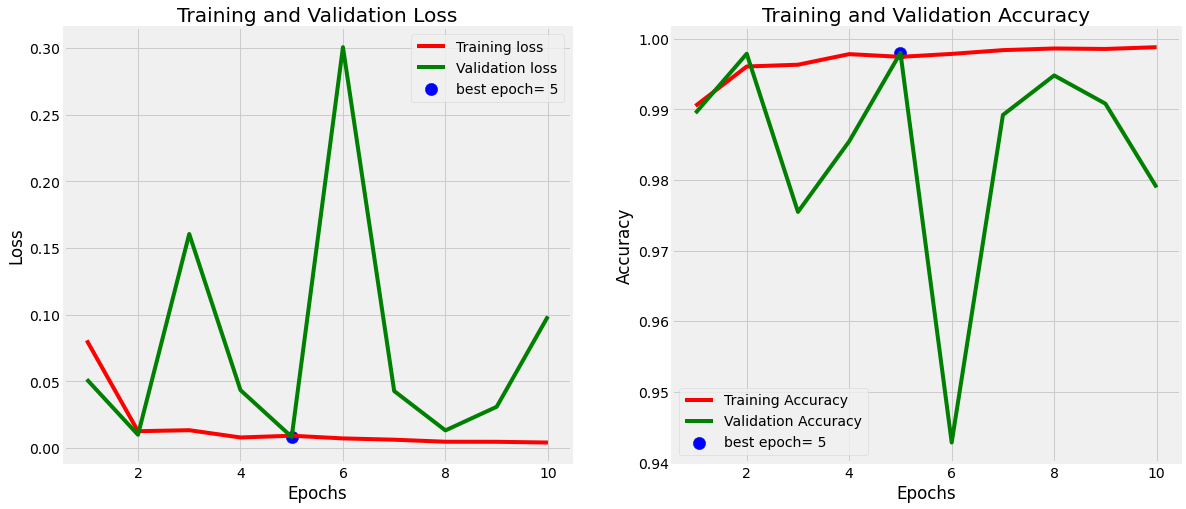

In [15]:
plot_training(history)

**Evaluate Model**

In [16]:
ts_length = len(test_df)
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

100/100 [==============================] - 15s 149ms/step - loss: 0.0832 - accuracy: 0.9780
Train Loss:  0.07670888304710388
Train Accuracy:  0.9815624952316284
--------------------
Validation Loss:  0.0969235897064209
Validation Accuracy:  0.9800000190734863
--------------------
Test Loss:  0.08318834006786346
Test Accuracy:  0.9779687523841858


**Confusion Matrix**

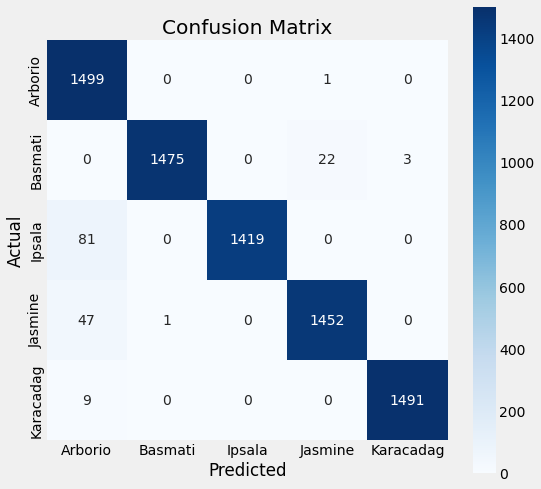

In [17]:
# Get predictions for the test data
y_pred = model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels for the test data
true_classes = test_gen.classes

# Compute confusion matrix
conf_matrix = confusion_matrix(true_classes, y_pred_classes)

# # Plot confusion matrix
# import seaborn as sns
# import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', square=True,
            xticklabels=test_gen.class_indices.keys(), yticklabels=test_gen.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

**Tuning The Model**

In [18]:
# Load the saved model
model = tf.keras.models.load_model('best_model.keras')

# Unfreeze some of the deeper layers for fine-tuning
for layer in model.layers[-10:]:
    layer.trainable = True

# Compile the model with a lower learning rate for fine-tuning
optimizer = Adamax(learning_rate=1e-5)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary after unfreezing
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

**Training The Fine-Tuned Model**

In [19]:
# Define callbacks for early stopping and model checkpoint
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1),
    tf.keras.callbacks.ModelCheckpoint('best_finetuned_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
]

# Fine-tune the model with the unfrozen layers
history_fine = model.fit(
    train_gen,
    epochs=15,
    validation_data=valid_gen,
    callbacks=callbacks
)

Epoch 1/15
938/938 [==============================] - ETA: 0s - loss: 0.0019 - accuracy: 0.9994
Epoch 00001: val_loss improved from inf to 0.00511, saving model to best_finetuned_model.keras


/root/miniconda3/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


938/938 [==============================] - 220s 229ms/step - loss: 0.0019 - accuracy: 0.9994 - val_loss: 0.0051 - val_accuracy: 0.9989
Epoch 2/15
938/938 [==============================] - ETA: 0s - loss: 0.0012 - accuracy: 0.9996
Epoch 00002: val_loss improved from 0.00511 to 0.00475, saving model to best_finetuned_model.keras
938/938 [==============================] - 213s 227ms/step - loss: 0.0012 - accuracy: 0.9996 - val_loss: 0.0048 - val_accuracy: 0.9991
Epoch 3/15
938/938 [==============================] - ETA: 0s - loss: 9.0978e-04 - accuracy: 0.9998
Epoch 00003: val_loss improved from 0.00475 to 0.00446, saving model to best_finetuned_model.keras
938/938 [==============================] - 214s 228ms/step - loss: 9.0978e-04 - accuracy: 0.9998 - val_loss: 0.0045 - val_accuracy: 0.9991
Epoch 4/15
938/938 [==============================] - ETA: 0s - loss: 7.3703e-04 - accuracy: 0.9998
Epoch 00004: val_loss improved from 0.00446 to 0.00436, saving model to best_finetuned_model.kera

**Display Model Performance**

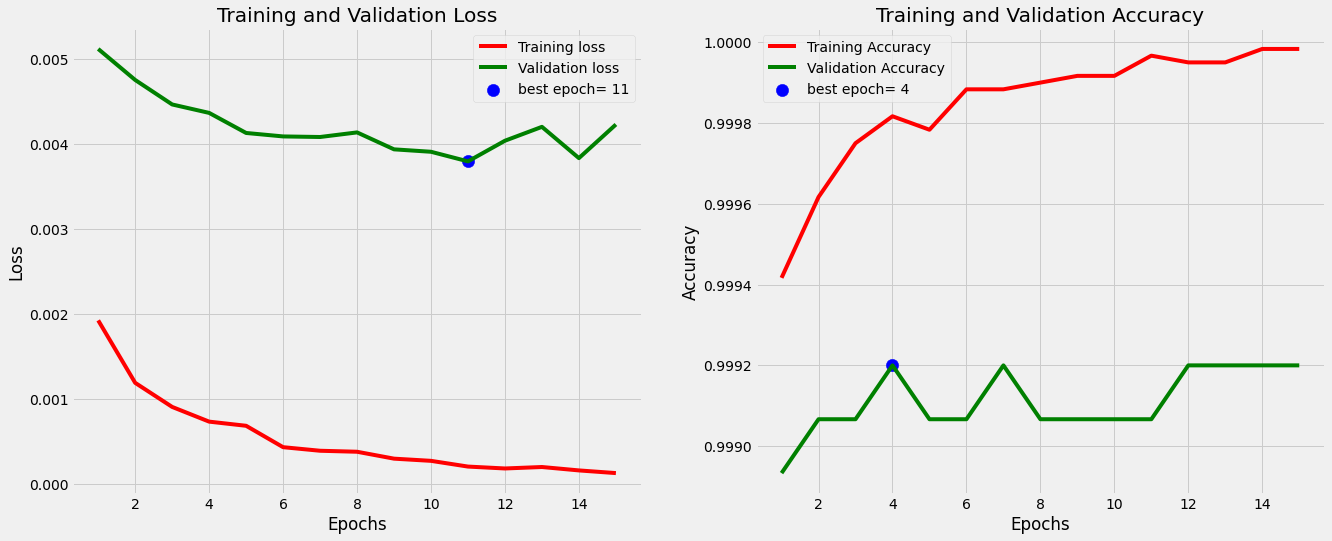

In [20]:
plot_training(history_fine)

**Evaluate Model**

In [18]:
ts_length = len(test_df)
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 159ms/step - accuracy: 1.0000 - loss: 1.1005e-05
100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 161ms/step - accuracy: 0.9997 - loss: 8.7603e-04
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 213ms/step - accuracy: 1.0000 - loss: 5.7537e-04
Train Loss:  1.0145507076231297e-05
Train Accuracy:  1.0
--------------------
Validation Loss:  0.0005887870211154222
Validation Accuracy:  0.9998437762260437
--------------------
Test Loss:  0.0015519465086981654
Test Accuracy:  0.9998437762260437


**Confusion Matrix**

In [ ]:
# Get predictions for the test data
y_pred = model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels for the test data
true_classes = test_gen.classes

# Compute confusion matrix
conf_matrix = confusion_matrix(true_classes, y_pred_classes)

# # Plot confusion matrix
# import seaborn as sns
# import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', square=True,
            xticklabels=test_gen.class_indices.keys(), yticklabels=test_gen.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()